In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import trange

sns.set_theme(context="notebook", style="whitegrid")
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

# 1. 导入数据

In [131]:
data = pd.read_csv("./FunnyTexts.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16670 entries, 0 to 16669
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      16670 non-null  int64 
 1   joke    16670 non-null  object
 2   label   16670 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 390.8+ KB


In [132]:
data.head()

,id,joke,label
0,0,阿华到市场买牛肉准备回家做料理，走到牛肉摊前买了一百元牛肉。 老板：请问牛肉要拿来做什么用的...,1
1,1,小伙子向心爱的女友求婚：“你长得如此美丽，我不知该如何表达对你的爱。” 女友说：“你可以用金...,3
2,2,阿月要亲自下厨煮饭问正在打麻将的母亲要洗多少米。妈妈没有听到阿月的问话。 一面将手里的牌打出...,5
3,3,专业知识的数量与公众理解的陈述数量成反比。,3
4,4,小偷儿到教堂做弥撒。 牧师问：什么风把你吹来了？这星期你没偷火鸡吧？ 没有，一只也没有偷。 ...,5


# 2. 数据集信息
## 2.1 文本长度统计

In [133]:
def length_describe(data, bins=20):
    # 得到字符串长度
    length_counts = data.str.len()
    # 绘制直方图
    plt.figure(figsize=(6, 5))
    sns.histplot(length_counts, bins=bins)
    plt.xlim(0)
    plt.xlabel("字符串长度", fontsize=16)
    plt.ylabel("频数", fontsize=16)
    plt.show()
    # 描述性统计
    print("描述性统计信息：\n{}".format(length_counts.describe()))

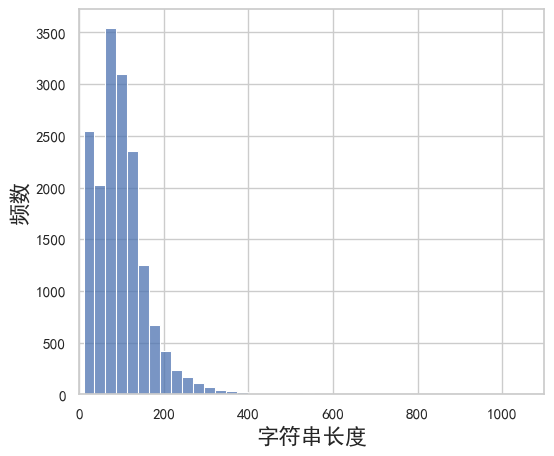

描述性统计信息：
count    16670.000000
mean        99.006179
std         65.544911
min         10.000000
25%         58.000000
50%         89.000000
75%        127.000000
max       1048.000000
Name: joke, dtype: float64


In [134]:
length_describe(data["joke"], bins=40)

In [135]:
length_counts = data["joke"].str.len()
data["len_joke"] = length_counts

In [136]:
content = data.loc[data["joke"].str.len() == 10].values[0]
print(content)

[8865 '妹妹：谁稀罕绿脸蛋。' 1 10]


In [137]:
data["joke"].loc[(data["label"] == 1) & (data["joke"].str.len() <= 20)].values

array(['于是，同学们起了个外号“新陈代谢”', '学生答：烧饼五毛钱一个，要么，要么？', 'A：你今天没课？ B：恩，主观没课～',
       '女儿：“妈妈，我想吃两个梨！”', '妹妹：谁稀罕绿脸蛋。', '他说：你给哥哥洗了两次，而我一次也没洗。',
       '老公：又跟人吵架了？ 夫人：没有，跟狗！', '爸爸：因为它是属鼠的，它怕人。', '小明说：益虫旁边是害虫，害虫旁边是益虫。',
       '孩子想了一下，坚定地说：站旁边！'], dtype=object)

## 2.2 标签统计

In [138]:
data["label"].value_counts()

label
3    8624
1    4408
5    3638
Name: count, dtype: int64

In [139]:
# 复制标签并重新命名
data["标签"] = data["label"]
data["标签"].replace({1: "弱幽默", 3: "一般幽默", 5: "强幽默"}, inplace=True)

In [140]:
# 替换标签
dict = {1: 0, 3: 1, 5: 2}
data["label"].replace(dict, inplace=True)
data["label"].value_counts()

label
1    8624
0    4408
2    3638
Name: count, dtype: int64

# 3. 筛选数据
考虑到模型运行速度，我们不得不选取字数较少的文本。

In [141]:
# 只使用文本量较少的数据
filtered_data = data.loc[data["joke"].str.len() <= 200, "joke":"标签"].reset_index(
    drop=True
)
filtered_data.head()

,joke,label,len_joke,标签
0,阿华到市场买牛肉准备回家做料理，走到牛肉摊前买了一百元牛肉。 老板：请问牛肉要拿来做什么用的...,0,114,弱幽默
1,小伙子向心爱的女友求婚：“你长得如此美丽，我不知该如何表达对你的爱。” 女友说：“你可以用金...,1,99,一般幽默
2,阿月要亲自下厨煮饭问正在打麻将的母亲要洗多少米。妈妈没有听到阿月的问话。 一面将手里的牌打出...,2,75,强幽默
3,专业知识的数量与公众理解的陈述数量成反比。,1,21,一般幽默
4,小偷儿到教堂做弥撒。 牧师问：什么风把你吹来了？这星期你没偷火鸡吧？ 没有，一只也没有偷。 ...,2,101,强幽默


In [150]:
filtered_data.to_csv("./FunnyTexts200.csv", index=False)

可视化

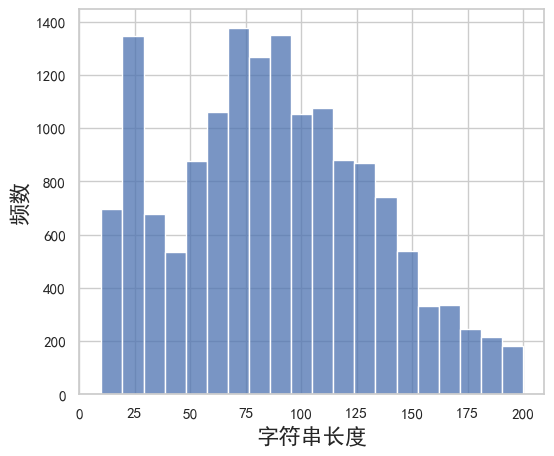

描述性统计信息：
count    15651.000000
mean        87.649479
std         44.413837
min         10.000000
25%         55.000000
50%         85.000000
75%        119.000000
max        200.000000
Name: joke, dtype: float64


In [142]:
length_describe(filtered_data["joke"], bins=20)

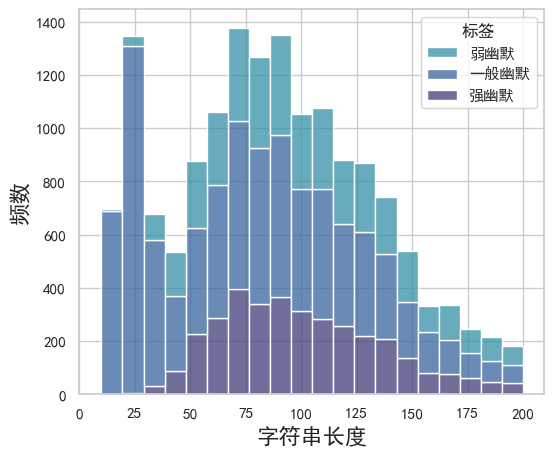

In [143]:
# 绘制直方图
plt.figure(figsize=(6, 5))
colors = sns.color_palette("mako_r")[2:5]
sns.histplot(
    data=filtered_data,
    x="len_joke",
    hue="标签",
    bins=20,
    multiple="stack",
    palette=colors,
)
plt.xlim(0)
plt.xlabel("字符串长度", fontsize=16)
plt.ylabel("频数", fontsize=16)
plt.show()

In [144]:
filtered_data["label"].value_counts()

label
1    8314
0    3876
2    3461
Name: count, dtype: int64

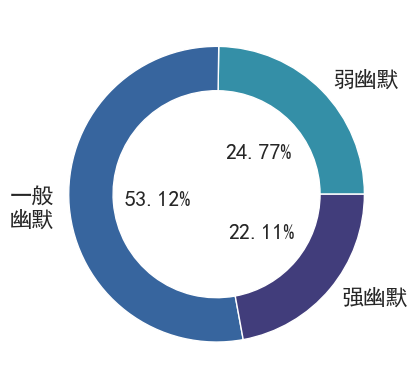

In [145]:
count = [3876, 8314, 3461]
label = ["弱幽默", "一般\n幽默", "强幽默"]

# define Seaborn color palette to use
colors = sns.color_palette("mako_r")[2:5]

# create pie chart
plt.pie(
    count,
    labels=label,
    autopct="%1.2f%%",
    colors=colors,
    textprops={"fontsize": 16},
    wedgeprops={"width": 0.3},
    pctdistance=0.4,
)
plt.show()

# 4. 数据划分

In [146]:
train_size = 0.8
train_dataset = filtered_data.sample(frac=train_size, random_state=648)
test_dataset = filtered_data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

In [148]:
train_dataset.to_csv("./train_dataset.csv", index=False)
test_dataset.to_csv("./test_dataset.csv", index=False)

# 5. 汉字转拼音

In [152]:
import pinyin

In [155]:
pinyin.get(data["joke"].iloc[2], format="numerical", delimiter=" ")

'a1 yue4 yao4 qin1 zi4 xia4 chu2 zhu3 fan4 wen4 zheng4 zai4 da3 ma2 jiang1 de5 mu3 qin1 yao4 xi3 duo1 shao3 mi3 。 ma1 ma1 mei2 you3 ting1 dao4 a1 yue4 de5 wen4 hua4 。   yi1 mian4 jiang1 shou3 li3 de5 pai2 da3 chu1 yi1 mian4 shuo1 dao4 ： jiu3 tong3 ！   jie2 guo3 … … na4 yi1 guo1 fan4 rang4 ta1 men5 jia1 zu2 zu2 chi1 le5 yi1 xing1 qi1 。'

In [157]:
train_dataset["pinyin"] = train_dataset["joke"].apply(
    lambda x: pinyin.get(x, format="numerical", delimiter=" ")
)
test_dataset["pinyin"] = test_dataset["joke"].apply(
    lambda x: pinyin.get(x, format="numerical", delimiter=" ")
)

In [159]:
train_dataset.to_csv("./train_dataset.csv", index=False)
test_dataset.to_csv("./test_dataset.csv", index=False)